In [2]:
## 1. Setup, Data Acquisition, and Cleaning

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 

# Set up visualization style
sns.set_style("whitegrid")

# Load Data
try:
    df = pd.read_csv('telco-customer-churn.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'telco-customer-churn.csv' not found. Please check your folder and file name.")
    exit()

# Initial Cleaning and Conversion

# 1. Drop CustomerID (not predictive and unique)
df = df.drop('customerID', axis=1)

# 2. Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3. Handle Missing Values (dropping rows with NaN TotalCharges)
df.dropna(inplace=True)

# 4. Convert 'Churn' (Target Variable) to numerical (1 for Yes, 0 for No)
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

# Display confirmation of cleaning
print("-" * 50)
print("Data Cleaning Complete.")
print("Shape of data after cleaning:", df.shape)
print("First 5 rows (Post-Cleaning):")
print(df.head())

Data loaded successfully.
--------------------------------------------------
Data Cleaning Complete.
Shape of data after cleaning: (7032, 20)
First 5 rows (Post-Cleaning):
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtecti

C:\Users\EIDEN W\AppData\Local\Temp\ipykernel_19664\749438123.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})



--- Churn Rate Analysis ---
Overall Churn Rate: 26.58%


C:\Users\EIDEN W\AppData\Local\Temp\ipykernel_19664\517304964.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contract', y='percent', data=contract_churn_pct, palette='viridis')


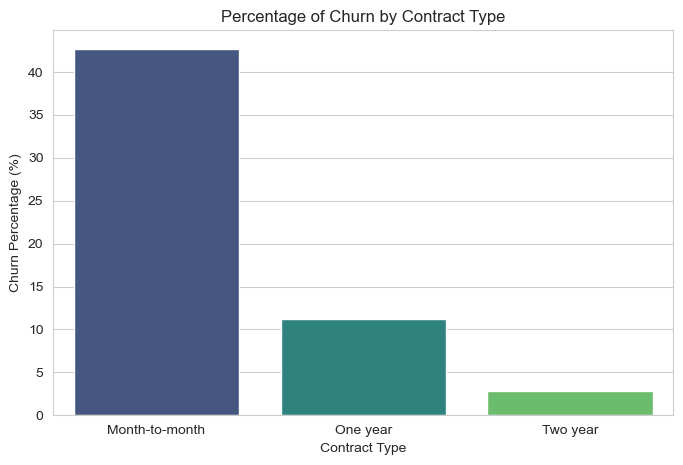

In [3]:
## 2. Exploratory Data Analysis (EDA) Summary

# Churn Rate Analysis 
print("\n--- Churn Rate Analysis ---")
churn_counts = df['Churn'].value_counts()
churn_rate = churn_counts[1] / df.shape[0]
print(f"Overall Churn Rate: {churn_rate:.2%}")

# Visualization: Churn by Contract Type
plt.figure(figsize=(8, 5))
# Calculate percentage of churn within each contract group for plotting
contract_churn_pct = df.groupby('Contract')['Churn'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
contract_churn_pct = contract_churn_pct[contract_churn_pct['Churn'] == 1]

sns.barplot(x='Contract', y='percent', data=contract_churn_pct, palette='viridis')
plt.title('Percentage of Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Percentage (%)')
plt.show()

# Business Insight: Month-to-month contracts have a drastically higher churn rate.

In [4]:
## 3. Preprocessing and Balancing Data

# Separate Features (X) and Target (y) ---
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify Feature Types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 1. One-Hot Encoding for Categorical Features 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Encode and create a DataFrame with feature names
X_categorical_encoded = encoder.fit_transform(X[categorical_cols])
X_categorical_encoded = pd.DataFrame(X_categorical_encoded, 
                                     columns=encoder.get_feature_names_out(categorical_cols), 
                                     index=X.index)

# 2. Standard Scaling for Numerical Features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X[numerical_cols])
X_numerical_scaled = pd.DataFrame(X_numerical_scaled, 
                                  columns=numerical_cols, 
                                  index=X.index)

# 3. Combine Processed Features 
X_processed = pd.concat([X_numerical_scaled, X_categorical_encoded], axis=1)

# 4. Split Data (Before SMOTE!) 
# Stratify ensures the test set has the same churn distribution as the full data.
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=42, stratify=y
)

# 5. Handling Imbalanced Data using SMOTE on TRAINING data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("-" * 50)
print("Data Preparation Complete.")
print(f"Churn Count BEFORE SMOTE: {y_train.sum()}")
print(f"Churn Count AFTER SMOTE: {y_train_resampled.sum()} (Balanced)")

--------------------------------------------------
Data Preparation Complete.
Churn Count BEFORE SMOTE: 1402
Churn Count AFTER SMOTE: 3872 (Balanced)


C:\Users\EIDEN W\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\EIDEN W\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\EIDEN W\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\EIDEN W\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\EIDEN W\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi


 Logistic Regression Performance 
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1291
           1       0.50      0.80      0.62       467

    accuracy                           0.74      1758
   macro avg       0.71      0.76      0.71      1758
weighted avg       0.80      0.74      0.75      1758

AUC-ROC Score: 0.8398

 Random Forest Performance (Use this for final Feature Importance)
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1291
           1       0.55      0.68      0.61       467

    accuracy                           0.77      1758
   macro avg       0.71      0.74      0.72      1758
weighted avg       0.79      0.77      0.78      1758

AUC-ROC Score: 0.8316


C:\Users\EIDEN W\AppData\Local\Temp\ipykernel_19664\3806412584.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


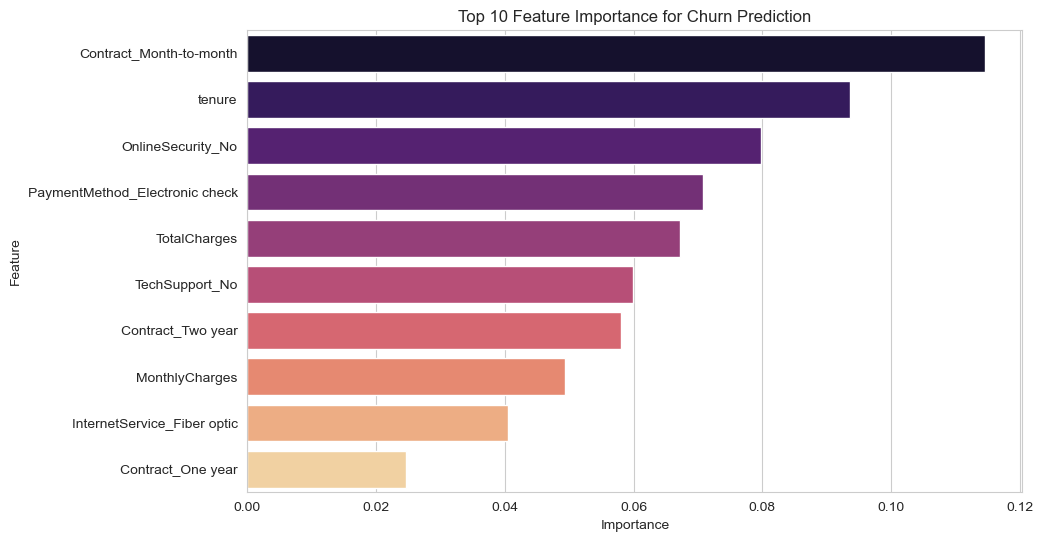


--- Top 3 Business Drivers of Churn ---
                    Feature  Importance
36  Contract_Month-to-month    0.114676
1                    tenure    0.093685
18        OnlineSecurity_No    0.079722


In [5]:
## 4. Modeling, Evaluation, and Feature Importance

# Model 1: Logistic Regression (Baseline)
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

print("\n Logistic Regression Performance ")
print(classification_report(y_test, y_pred_lr))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")

# Model 2: Random Forest (Recommended for Interpretation)
# A good starting point for hyperparameter tuning
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42) 
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n Random Forest Performance (Use this for final Feature Importance)")
report = classification_report(y_test, y_pred_rf, output_dict=True)
print(classification_report(y_test, y_pred_rf))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")
# Note: In Churn Prediction, focus on the Recall for '1' (Churn) to catch as many leaving customers as possible.

# Feature Importance Extraction
final_model = rf_model
importances = final_model.feature_importances_
feature_names = X_processed.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Visualization: Top 10 Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Top 10 Feature Importance for Churn Prediction')
plt.show()

# FINAL BUSINESS TAKEAWAY 
print("\n--- Top 3 Business Drivers of Churn ---")
print(feature_importance_df.head(3))

In [6]:
import os
print(os.getcwd())

C:\Users\EIDEN W\Telco_Churn_Project
